In [1]:
print("hello")

hello


In [1]:
from datasets import load_dataset
from fastai.vision.all import *
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from concept_helpers.DeepView_Craft import CraftTorchDV as Craft
from concept_helpers.DeepView_Craft import CraftTorchSupervised as CraftS
from concept_helpers.combined_crafts import CombinedCrafts

import urllib.request
import glob
import torch
import torch.nn as nn
from torchvision import transforms
import timm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from scipy.sparse.linalg import eigs
from sklearn.ensemble import  RandomForestClassifier

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import random

from xplique.concepts.craft import BaseCraft, DisplayImportancesOrder, Factorization, Sensitivity
from sklearn.decomposition import non_negative_factorization
from experiment_helpers.helper_function import *
from experiment_helpers.driftLocalizer import Localizer


np.random.seed(68)

device = 'cuda'

# loading any timm model
model = timm.create_model('nf_resnet50.ra2_in1k', pretrained=True)
model = model.to(device)

# processing
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
to_pil = transforms.ToPILImage()

# cut the model in twop arts (as explained in the paper)
# first part is g(.) our 'input_to_latent' model, second part is h(.) our 'latent_to_logit' model
g = nn.Sequential(*(list(model.children())[:4]))  # input to penultimate layer
h = nn.Sequential(*(list(model.children())[4:]))  # penultimate layer to logits


with urllib.request.urlopen('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt') as f:
        imagenet_class_names = np.array(f.read().decode('utf-8').split('\n'))

def gen_images(filelist,folder_names,folder_name2class_id):
        for f in filelist:
            
            folder_name = f.split('/')[-2]
            if folder_name in folder_names:
                class_id = folder_name2class_id[folder_name]
                im = Image.open(f)
                if len(im.getbands()) == 3:
                    yield np.array(im.resize((224, 224))), class_id

idd_folder = '/home/iroberts/projects/concepts_deepview/data/drift_detection/'


idd_folder_names = os.listdir('/home/iroberts/projects/concepts_deepview/data/drift_detection/')
idd_class_names = idd_folder_names

idd_class_ids = [np.where(imagenet_class_names == class_name)[0][0] for class_name in idd_class_names]
folder_name2class_id = dict(zip(idd_folder_names, idd_class_ids))
filelist = glob.glob(f'{idd_folder}/*/*.jpg')


images, labels = zip(*gen_images(filelist,idd_folder_names,folder_name2class_id))
images, labels = np.array(images), np.array(labels)
preprocessed_images = torch.stack([transform(to_pil(img)) for img in images], 0)
print(preprocessed_images.shape)

# np.random.seed(3)
sample_ids = np.random.choice(len(preprocessed_images),500, False)

sample_images = preprocessed_images[sample_ids]


# Map each digit to a label indicating whether it occurs before or after the change point, or both, or neither
#  0 - never, 1 - before, 2 - after, 3 - both

# 0-before, 1-after
label_map = {
    269: 2,
    270: 1,
    271: 0,
    277: 2,
    279: 0,
    280: 1,
}
# {
#     'timber wolf': 269
#      'white wolf': 270
# 'red wolf': 271,
#  'red fox': 277,
#     'Arctic fox': 279,
#  'grey fox': 280,

#  }

labels_mapped = np.array([label_map[class_id] for class_id in labels])

drift_labels = labels_mapped[sample_ids]

patch_size = 256

# Randomly assign labels of 1 or 2 to samples with label 3
#  (i.e., digits that occur both before and after the change point)
label_2_idx = np.where(drift_labels == 2)[0]
y_mixed = drift_labels.copy()
y_mixed[label_2_idx] = np.random.choice([0, 1], size=len(label_2_idx))

sample_labels = y_mixed

#Supervised CRAFT Training
h_craftdv = CraftS(input_to_latent_model=g,
                    latent_to_logit_model=h,
                    number_of_concepts=5,
                    inputs=sample_images,
                    labels=sample_labels,
                    batch_size=64,
                    patch_size=patch_size,
                    device=device)

patches, patch_act, train_labels = h_craftdv._extract_patches(sample_images, sample_labels )


2024-11-21 13:22:21.479624: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 13:22:21.503442: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 13:22:21.695627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 13:22:22.704971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


torch.Size([2777, 3, 256, 256])


In [2]:
{"BD": len(np.where(drift_labels == 0)[0]),
                         "AD": len(np.where(drift_labels == 1)[0]),
                         "Both": len(np.where(drift_labels == 2)[0])}

{'BD': 163, 'AD': 182, 'Both': 155}

In [3]:
print(len(sample_labels[np.where(labels[sample_ids] == 277)[0]]))
print(len(sample_labels[np.where(labels[sample_ids] == 280)[0]]))
print(len(sample_labels[np.where(labels[sample_ids] == 279)[0]]))
print(len(sample_labels[np.where(labels[sample_ids] == 270)[0]]))
print(len(sample_labels[np.where(labels[sample_ids] == 269)[0]]))
print(len(sample_labels[np.where(labels[sample_ids] == 271)[0]]))


53
81
70
101
102
93


In [4]:
bd_indices = np.where(sample_labels != 1)[0]
ad_indices = np.where(sample_labels != 0)[0]

In [5]:
patch_size = 100
bd_fit = Craft(input_to_latent_model=g,
                    latent_to_logit_model=h,
                    number_of_concepts=10,
                    # labels=h_y,
                    patch_size=patch_size,
                    batch_size=64,
                    device=device)
print("Fitting Unsupervised Craft....")
bd_crops, bd_crops_u, bd_w = bd_fit.fit(sample_images[bd_indices])


ad_fit = Craft(input_to_latent_model=g,
                    latent_to_logit_model=h,
                    number_of_concepts=10,
                    # labels=h_y,
                    patch_size=patch_size,
                    batch_size=64,
                    device=device)
print("Fitting Unsupervised Craft....")
ad_crops, ad_crops_u, ad_w = ad_fit.fit(sample_images[ad_indices])

drift_basis = np.vstack([bd_w, ad_w])

drift_craft = CombinedCrafts(input_to_latent_model=g,
                    latent_to_logit_model=h,
                    number_of_concepts=len(drift_basis),
                    inputs=sample_images,
                    labels=sample_labels,
                    basis = drift_basis,
                    batch_size=64,
                    patch_size=patch_size,
                    device=device)

print("Fitting Craft....")
drift_craft.transform_all()

Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Unsupervised Craft....


In [9]:
from sklearn.metrics import log_loss
X_clean = patch_act
y_clean = sample_labels

localizer=Localizer()

localizer.fit(X_clean,y_clean)



In [ ]:
label_map = {
    269: 0,
    270: 0,
    271: 1,
    277: 2,
    279: 2,
    280: 1,
}

{
    'timber wolf': 269
     'white wolf': 270
'red wolf': 271,
 'red fox': 277,
    'Arctic fox': 279,
 'grey fox': 280,

 }

In [13]:
drift_imp = np.round(estimate_importance(X_clean),3)

y_preds, _ = l_compute_predictions(localizer,X_clean)

image_drift_imp = [estimate_importance_helper(image,class_of_interest=y_preds[i]) 
                               for i,image in enumerate(X_clean)]

In [17]:
accuracy_score(y_preds,sample_labels)

0.948

In [18]:
print(local_one_imp_concept_globally(drift_craft,image_drift_imp, sample_labels))
print(local_imp_concepts_globally(drift_craft,image_drift_imp,1, sample_labels))
print(local_imp_concepts_globally(drift_craft,image_drift_imp,2, sample_labels))
print(local_imp_concepts_globally(drift_craft,image_drift_imp,3, sample_labels))
print(global_imp_concepts_locally(drift_craft,image_drift_imp, 1, sample_labels))
print(global_imp_concepts_locally(drift_craft,image_drift_imp,2, sample_labels))
print(global_imp_concepts_locally(drift_craft,image_drift_imp,3, sample_labels))

0.83
0.826
0.812
0.78
0.606
0.804
0.814


In [19]:
print(local_one_imp_concept_globally(drift_craft,image_drift_imp, y_preds))
print(local_imp_concepts_globally(drift_craft,image_drift_imp,1, y_preds))
print(local_imp_concepts_globally(drift_craft,image_drift_imp,2, y_preds))
print(local_imp_concepts_globally(drift_craft,image_drift_imp,3, y_preds))
print(global_imp_concepts_locally(drift_craft,image_drift_imp, 1, y_preds))
print(global_imp_concepts_locally(drift_craft,image_drift_imp,2, y_preds))
print(global_imp_concepts_locally(drift_craft,image_drift_imp,3, y_preds))

0.838
0.838
0.828
0.808
0.638
0.848
0.842


In [114]:
bd_dist, ad_dist = concept_counter(image_drift_imp, y_preds,1)

In [14]:
from collections import Counter
import numpy as np

sample_local_imp = np.array(image_drift_imp)
# Initialize counters for before drift (0), after drift (1), and both (2)
before_drift_counter = Counter()
after_drift_counter = Counter()
both_drift_counter = Counter()

# Iterate over each drift label (assuming 0 = before drift, 1 = after drift, 2 = both)
for drift_label in np.unique(sample_labels):
    # Filter the images for the current drift label
    drift_fil = y_preds == drift_label

    # Iterate over each image's importance vector
    for image_imp in sample_local_imp[drift_fil]:
        # Sort the importance vector and get the most important local concept (the index)
        local_imp_sort = np.argsort(image_imp)[::-1][0]
        
        # Update the respective counter based on drift label
        if drift_label == 0:
            before_drift_counter[local_imp_sort] += 1
        elif drift_label == 1:
            after_drift_counter[local_imp_sort] += 1
        elif drift_label == 2:
            both_drift_counter[local_imp_sort] += 1

# Print the distributions of the most important concepts for each drift phase
print("Distribution of most important concepts before drift:")
for concept, count in before_drift_counter.items():
    print(f"Concept {concept}: {count} times")

print("\nDistribution of most important concepts after drift:")
for concept, count in after_drift_counter.items():
    print(f"Concept {concept}: {count} times")

print("\nDistribution of most important concepts in both drift phases:")
for concept, count in both_drift_counter.items():
    print(f"Concept {concept}: {count} times")

# Optionally, extract and compare the top N varying concepts for each drift phase
top_n = 5  # You can adjust this value to focus on the top N varying concepts

print(f"\nTop {top_n} most important concepts before drift:")
for concept, count in before_drift_counter.most_common(top_n):
    print(f"Concept {concept}: {count} occurrences")

print(f"\nTop {top_n} most important concepts after drift:")
for concept, count in after_drift_counter.most_common(top_n):
    print(f"Concept {concept}: {count} occurrences")

print(f"\nTop {top_n} most important concepts in both drift phases:")
for concept, count in both_drift_counter.most_common(top_n):
    print(f"Concept {concept}: {count} occurrences")

Distribution of most important concepts before drift:
Concept 3: 80 times
Concept 0: 5 times
Concept 18: 20 times
Concept 5: 49 times
Concept 4: 35 times
Concept 1: 23 times
Concept 13: 3 times
Concept 9: 12 times
Concept 11: 3 times
Concept 15: 2 times

Distribution of most important concepts after drift:
Concept 13: 101 times
Concept 11: 81 times
Concept 18: 14 times
Concept 4: 49 times
Concept 15: 1 times
Concept 10: 5 times
Concept 14: 2 times
Concept 3: 1 times
Concept 12: 3 times
Concept 5: 4 times
Concept 1: 3 times
Concept 6: 2 times
Concept 9: 1 times
Concept 0: 1 times

Distribution of most important concepts in both drift phases:

Top 5 most important concepts before drift:
Concept 3: 80 occurrences
Concept 5: 49 occurrences
Concept 4: 35 occurrences
Concept 1: 23 occurrences
Concept 18: 20 occurrences

Top 5 most important concepts after drift:
Concept 13: 101 occurrences
Concept 11: 81 occurrences
Concept 4: 49 occurrences
Concept 18: 14 occurrences
Concept 10: 5 occurrenc

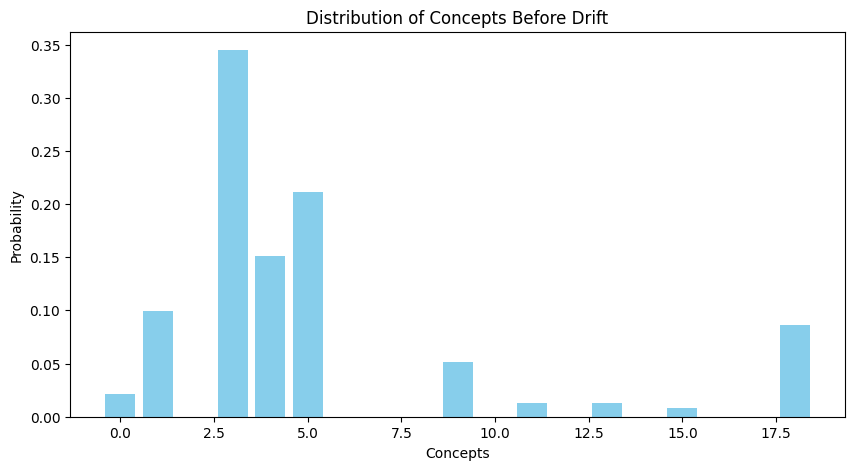

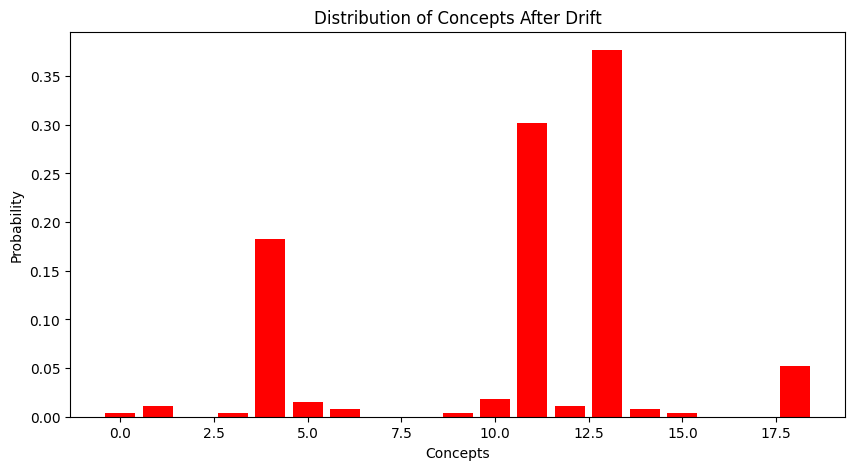

In [15]:
import matplotlib.pyplot as plt

# Calculate total counts for each drift phase
total_before = sum(before_drift_counter.values())
total_after = sum(after_drift_counter.values())
total_both = sum(both_drift_counter.values())

# Normalize counts to create probability distributions
before_drift_dist = {concept: count / total_before for concept, count in before_drift_counter.items()}
after_drift_dist = {concept: count / total_after for concept, count in after_drift_counter.items()}
both_drift_dist = {concept: count / total_both for concept, count in both_drift_counter.items()}

# Sort concepts by their probability for each distribution
sorted_before = sorted(before_drift_dist.items(), key=lambda x: x[1], reverse=True)
sorted_after = sorted(after_drift_dist.items(), key=lambda x: x[1], reverse=True)
sorted_both = sorted(both_drift_dist.items(), key=lambda x: x[1], reverse=True)

# Plot the distributions
def plot_distribution(dist, title, color):
    concepts, probs = zip(*dist)
    plt.figure(figsize=(10, 5))
    plt.bar(concepts, probs, color=color)
    plt.xlabel('Concepts')
    plt.ylabel('Probability')
    plt.title(title)
    plt.show()

# Plot the distributions for before drift, after drift, and both
plot_distribution(sorted_before, "Distribution of Concepts Before Drift", "skyblue")
plot_distribution(sorted_after, "Distribution of Concepts After Drift","red")
# plot_distribution(sorted_both, "Distribution of Concepts in Both Drift Phases", "purple")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Example function to load an image and return an OffsetImage
def get_image_for_concept(concept):
    nb_crops = 1
    best_crops_ids = np.argsort(drift_craft.factorization.crops_u[:, concept])[::-1][:nb_crops]
    best_crop = np.array(drift_craft.factorization.crops)[best_crops_ids]
    best_crop = best_crop.squeeze()  # Remove the batch dimension (shape: (3, H, W))
    best_crop = np.transpose(best_crop, (1, 2, 0))  # Reshape the crop from (3, H, W) to (H, W, 3)
    best_crop -= best_crop.min()
    best_crop /= best_crop.max()
    # print(best_crop.shape)
    return OffsetImage(best_crop, zoom=0.37)



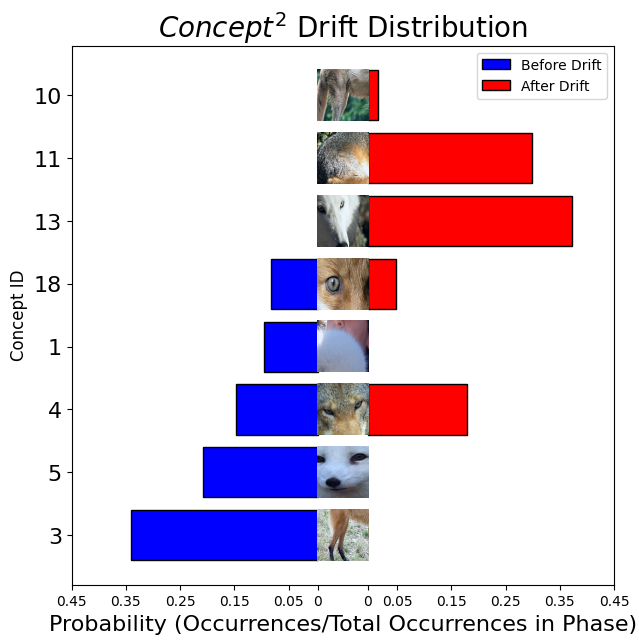

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Example function to load an image and return an OffsetImage
def get_image_for_concept(concept):
    nb_crops = 1
    best_crops_ids = np.argsort(drift_craft.factorization.crops_u[:, concept])[::-1][:nb_crops]
    best_crop = np.array(drift_craft.factorization.crops)[best_crops_ids]
    best_crop = best_crop.squeeze()  # Remove the batch dimension (shape: (3, H, W))
    best_crop = np.transpose(best_crop, (1, 2, 0))  # Reshape the crop from (3, H, W) to (H, W, 3)
    best_crop -= best_crop.min()
    best_crop /= best_crop.max()
    # print(best_crop.shape)
    return OffsetImage(best_crop, zoom=0.37)
    
def plot_distribution_with_images(bd_dist, ad_dist):
    # Extract concepts and probabilities
    bd_concepts, bd_probs = zip(*bd_dist)
    ad_concepts, ad_probs = zip(*ad_dist)

    # Restrict to top 5 concepts for both before and after drift
    ad_probs = np.array(list(ad_probs))[:5]
    bd_probs = np.array(list(bd_probs))[:5]
    ad_concepts = np.array(list(ad_concepts)).astype(str)[:5]
    bd_concepts = np.array(list(bd_concepts)).astype(str)[:5]
    
    # Combine all concepts for consistent y-axis labeling
    concepts = np.append(bd_concepts, ad_concepts)

    fig, ax = plt.subplots(figsize=(7, 7))

    # Define bar offsets to avoid overlap with images
    bar_offset = 0.046  # Offset to shift bars without altering magnitude

    # Plot the bar charts with the offset
    ax.barh(bd_concepts, -bd_probs, color='blue', edgecolor="black", label='Before Drift', left=-bar_offset)
    ax.barh(ad_concepts, ad_probs, color='red', edgecolor="black", label='After Drift', left=bar_offset)

    # Add images between bars
    for i, concept in enumerate(np.unique(concepts)):
        # Get the image for the current concept
        image = get_image_for_concept(int(concept))

        # Define the position where the image should be placed
        y_coord = concept  # Sequentially label the y-axis
        x_coord = 0  # X position (center between positive and negative bars)

        # Create an AnnotationBbox for the image and add it to the plot
        ab = AnnotationBbox(image, (x_coord, y_coord), frameon=False)
        ax.add_artist(ab)

    # Adjust y-ticks and label
    ax.set_yticks(np.unique(concepts))
    ax.set_yticklabels([f"{concept}" for concept in np.unique(concepts)], fontsize=16)
    
    # Scale and adjust the x-axis limits
    max_prob = max(np.max(ad_probs), np.max(bd_probs))
    # ax.set_xlim(-max_prob - 0.1, max_prob + 0.1)  # Ensure symmetric axis with space for offsets
    # Define the tick positions and labels
    # Define the tick positions
    tick_positions = [-0.5, -0.4, -0.3, -0.2, -0.1, -.046, 0.046, 0.1, 0.2, 0.3, 0.4, 0.5]
    
    # Define corresponding tick labels
    tick_labels = ["0.45", "0.35", "0.25", "0.15", "0.05", "0", "0", "0.05", "0.15", "0.25", "0.35", "0.45"]
    
    # Set the tick positions and labels
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    # ax.set_xticklabels([f"{label}" if label != 0 else "0" + ("\u200A" if i % 2 == 0 else "") 
                        # for i, label in enumerate(tick_labels)])
        
    # Add labels and legend
    ax.set_xlabel("Probability (Occurrences/Total Occurrences in Phase)", fontsize=16)
    ax.set_ylabel("Concept ID", fontsize=12)
    ax.set_title("$Concept^2$ Drift Distribution", fontsize=20)
    ax.legend()

    # Show the plot
    plt.show()



plot_distribution_with_images(sorted_before, sorted_after)


In [ ]:
np.where(y_preds == 0)[0]

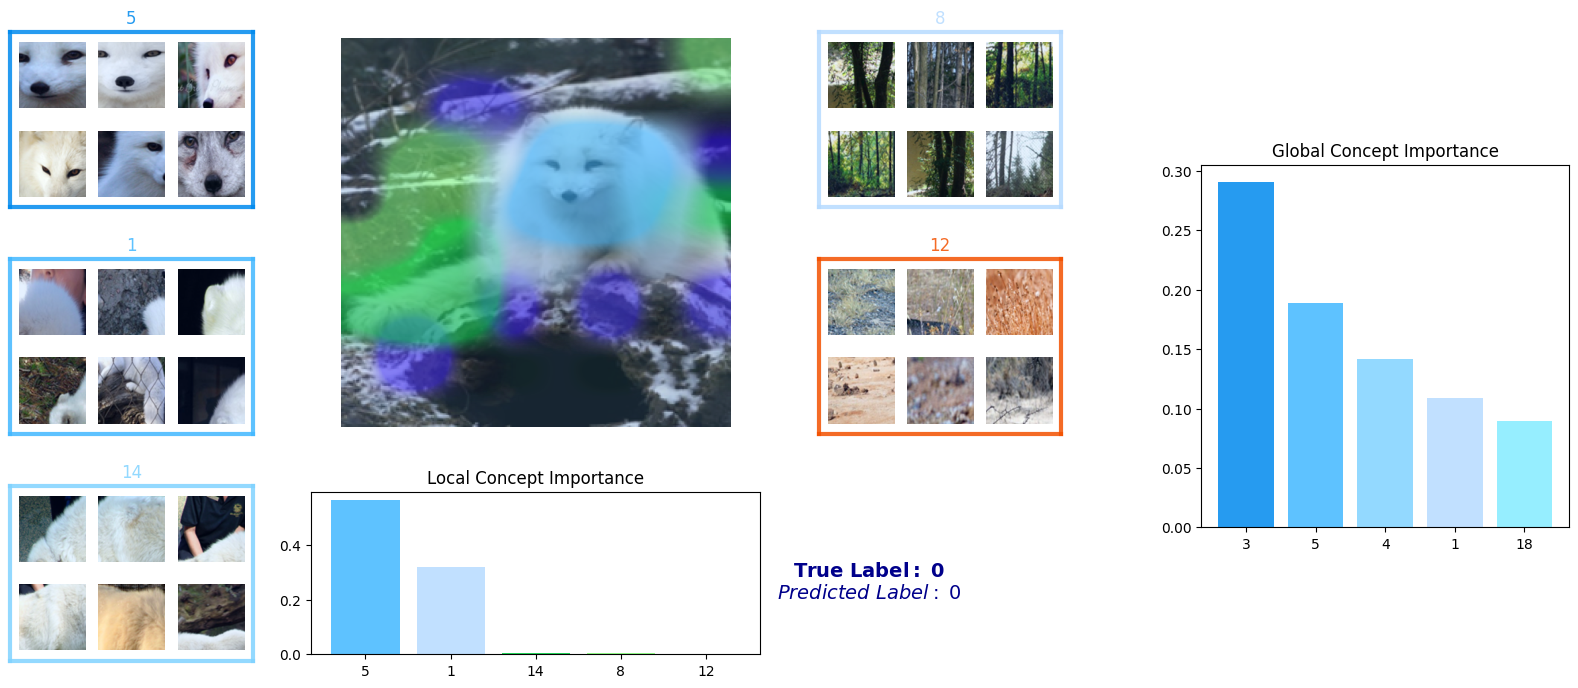

In [27]:
image_id = 52
t = X_clean[image_id]
local_image_drift_imp = estimate_importance_helper(t,class_of_interest=y_preds[image_id])

drift_craft.plot_image_concepts(sample_images[image_id].cpu(), img_local_importance=local_image_drift_imp,
                                        yt=drift_labels[image_id], yp=y_preds[image_id])

In [ ]:
from math import ceil
nb_crops = 3
best_crops_ids = np.argsort(drift_craft.factorization.crops_u[:, 12])[::-1][:nb_crops]
best_crops = np.array(drift_craft.factorization.crops)[best_crops_ids]
fig = plt.figure(figsize=(7, (2.5/2)*ceil(nb_crops/5)))
for i in range(nb_crops):
    drift_craft._show(best_crops[i])
    
